In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BaselineModel()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

BaselineModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
# Function to generate adversarial image using FGSM attack
def generate_adversarial_image(image, epsilon=0.03): 
    image.requires_grad = True

    output = model(image)
    _, predicted = torch.max(output.data, 1)
    loss = F.cross_entropy(output, predicted)

    model.zero_grad()
    loss.backward()
    
    perturbed_image = image + epsilon * image.grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1).detach()

    return perturbed_image

In [5]:
# Load and preprocess the input image
input_image_path = r'attack_test\org_int_images\airplane.jpg'
original_image = Image.open(input_image_path)
input_image = Image.open(input_image_path)
input_image_tensor = transform(input_image).unsqueeze(0)

In [6]:
# Generate adversarial image
adversarial_image = generate_adversarial_image(input_image_tensor)

# Convert tensors to images for display and saving
input_image = transforms.ToPILImage()(input_image_tensor.squeeze())
adversarial_image = transforms.ToPILImage()(adversarial_image.squeeze())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


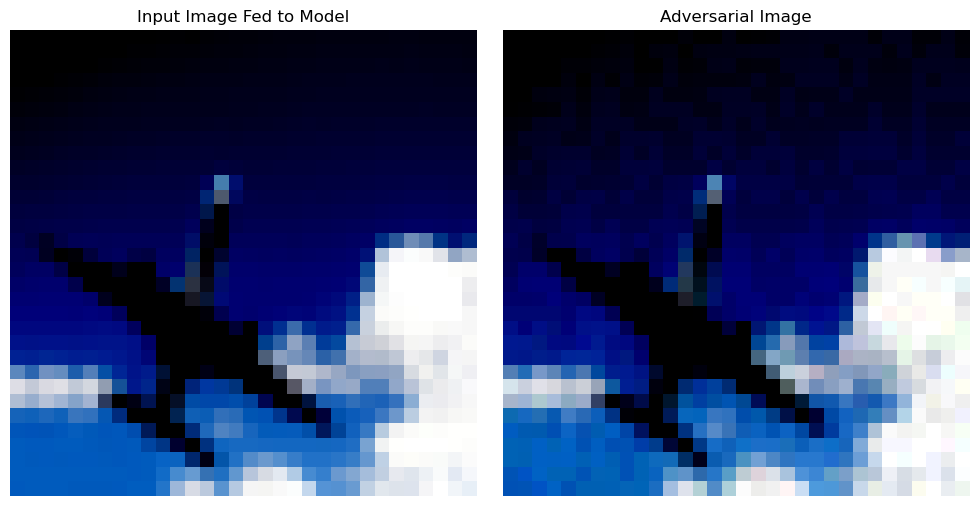

In [7]:
# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Input Image Fed to Model')
input_image_numpy = input_image_tensor.squeeze().permute(1, 2, 0).detach().numpy()
plt.imshow(input_image_numpy)
plt.axis('off')


plt.subplot(1, 2, 2)
plt.title('Adversarial Image')
plt.imshow(adversarial_image)
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the adversarial image
# adversarial_image_path = r'attack_test\advcifar\advautomobile.jpg'
# adversarial_image.save(adversarial_image_path)